# Prediction of mass by using the scalar field and position

Two models, one dense, one convolutional attempt to predict the mass of particles moving in a force field.  

The Dense model works on a dataset with 50 different fields and 2000 simulations across them. It achieves about 0.7 correlation. And is only able to predict the mean when using the full dataset.

The Convolutional model works on a dataset with 2000 fields and one simulation per field. 

#### Imports

In [112]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
from dataset import DataBuilder, final_positions_hist, plot_field
from FFNN_models import CNN, DenseNN

In [2]:
%load_ext autoreload
%autoreload 2

## Dataset production
Field has shape (32,32) by default. 

In [86]:
data = DataBuilder(sim_steps=200, downsize=True)

### Complete dataset
Data set with $n$ random fields and $n$ random masses

In [5]:
x, y = data.build()

Produced 2500 samples
Ignored 0 simulations which gave IndexError
Size of data set: 2500


In [6]:
x_train = x[:2200]
x_test = x[2200:]
y_train = y[:2200]
y_test = y[2200:]

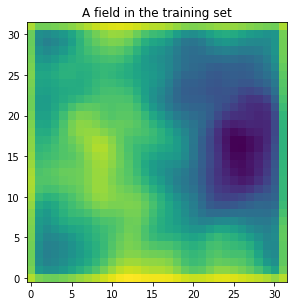

In [18]:
plot_field(x_train[0])
plt.show() # plots double without

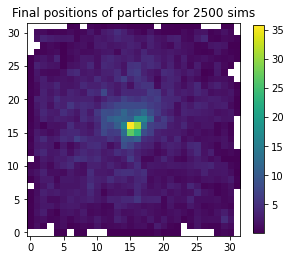

In [27]:
final_positions_hist(x, title="Final positions of particles for 2500 sims")
plt.show()

### Dataset with 20 fields
A dataset with multiple fields and with multiple simulations of each field. 

In [87]:
x20, y20, colors = data.build_n_fields(20)

Produced 20 fields
Produced 2500 samples
Ignored 0 simulations which gave IndexError
Size of data set: 2500


In [88]:
x20_train = x20[:2200]
x20_test = x20[2200:]
y20_train = y20[:2200]
y20_test = y20[2200:]
train_color = colors[:2200]
test_color = colors[2200:]

Fields below can be repeated because it is the first nine fields of the set, not the first nine fields of the 20.

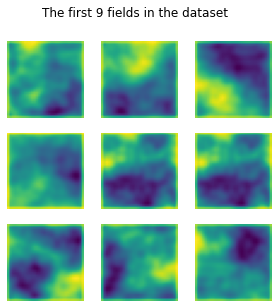

In [89]:
plot_field(nine_fields=x20_train[:9])
plt.show()

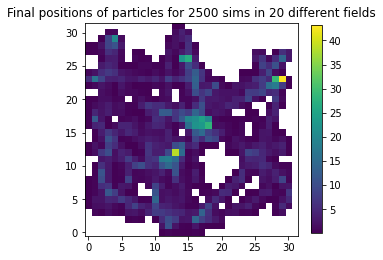

In [90]:
final_positions_hist(x20, title="Final positions of particles for 2500 sims in 20 different fields")
plt.show()

## Dense Model
A simple dense model that flattens the input field 32x202 and input position 32x202 to a (2048,) tensor  

It is unable to learn how fields behave as in the standard datasett (x1,y1), but is able to learn multiple fields quite well with the Dataset with 50 fields (x20, y20). 

Structure:  
 -Flatten  
 -Dense  
 -Dense 
 -Output  


### Dense trained on complete dataset

In [130]:
dense1 = DenseNN(name="DenseModel")

In [131]:
dense1.set_dataset(x_train, y_train, x_test, y_test)

Trained with only epoch to so that it must understand the fields' effect on the particles and cannot memoriz

In [132]:
dense1.train(3,1)

In [133]:
dense1.predict(pred_on_train=True)

R2 score of model:  -0.10585149220660228
Normalised covariance between predicted and actual mass is 0.07757331204666582


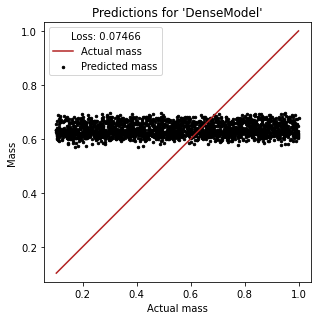

In [134]:
dense1.plot_test()
plt.show()

### Dense trained on dataset with 20 fields

In [263]:
dense2 = DenseNN(name="Dense_20fields")

In [264]:
dense2.set_dataset(x20_train, y20_train, x20_test, y20_test)

In [317]:
dense2.train(10,50)

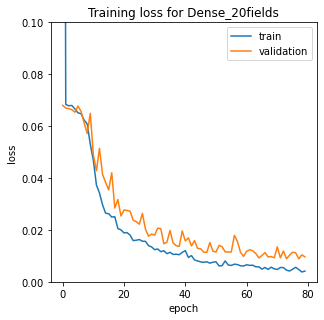

In [292]:
dense2.plot_training()
plt.ylim((0,0.1))
plt.show()

In [299]:
dense2.predict()

MSE score of model:  0.008126435251488873
R2 score of model:  0.8754877309390499
Normalised covariance between predicted and actual mass is 0.9471995882331687


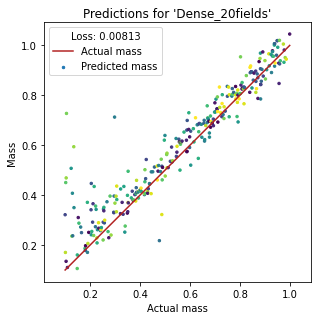

In [300]:
dense2.plot_test(color=test_color)
plt.show()

In [335]:
n = 10
R2_dense = np.zeros(n)
MSE_dense = np.zeros(n)
for i in range(n):
    if i == 0:
        j = 1
    elif i == n:
        j = n-1
    else:
        j = i
    print("Models trained: ", i, f"Average R2: {R2_dense[:j].mean():.4f}, \
          Average MSE: {MSE_dense[:j].mean():.4f}" "\r", end="", flush=True)
    dense2.reinitialize_weights()
    dense2.train(10,70)
    dense2.predict()
    R2_dense[i] = dense2.r2
    MSE_dense[i]= dense2.mse

print(f"Average R2 of {n} dense models: {R2_dense.mean()}")
print(f"Average MSE of {n} dense models: {MSE_dense.mean()}")

Average R2 of 10 dense models: 0.9130506625946643Average MSE: 0.0057
Average MSE of 10 dense models: 0.005674847674958333


array([0.91195102, 0.90636183, 0.89898121, 0.89633691, 0.91176924,
       0.90690647, 0.90058988, 0.90279357, 0.91284247, 0.91254549,
       0.91102761, 0.91477516, 0.91605898, 0.91785473, 0.91836613,
       0.90543398, 0.91115282, 0.90874685, 0.9139531 , 0.91134206])

## Convolutional Model
A convolutional model with input shape (32,32,2). Three convolutional layers with 32, 64, and 10 filters and finally a 32 node dense layer before the output layer. 

### Convolutional model on full dataset 

In [177]:
Conv1 = CNN(name="Conv_model")

In [178]:
Conv1.set_dataset(x_train, y_train, x_test, y_test)

Trained with only epoch to so that it must understand the fields' effect on the particles and cannot memorize the fields

In [179]:
Conv1.train(3,1)

In [180]:
Conv1.predict(pred_on_train=True)

R2 score of model:  -0.031425523612116146
Normalised covariance between predicted and actual mass is 0.0035837668798265154


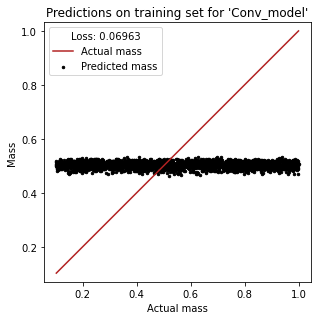

In [181]:
Conv1.plot_test(title="Predictions on training set for 'Conv_model'")
plt.show()

The model is not able to learn how the fields affect the position and is only able to learn the mean. We use the simpler dataset with multiple simulations on only 20 fields below to see if it is able to learn anything about at all about the fields.

### Convolutional Model on dataset with 20 fields


In [260]:
conv2 = CNN(name="Conv_20fields")
conv2.model.summary()

Model: "Conv_20fields"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolutional_1 (Conv2D)     (None, 32, 32, 10)        190       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 10)          0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 640)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 32)                20512     
_________________________________________________________________
Prediction (Dense)           (None, 1)                 33        
Total params: 20,735
Trainable params: 20,735
Non-trainable params: 0
_________________________________________________________________


In [261]:
conv2.set_dataset(x20_train, y20_train, x20_test, y20_test)

In [316]:
conv2.train(5,50, verbose=1)

Epoch 1/50
352/352 [==============================] - 2s 4ms/step - loss: 0.0032 - val_loss: 0.0074
Epoch 2/50
352/352 [==============================] - 2s 5ms/step - loss: 0.0030 - val_loss: 0.0075
Epoch 3/50
352/352 [==============================] - 2s 4ms/step - loss: 0.0031 - val_loss: 0.0076
Epoch 4/50
352/352 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0.0080
Epoch 5/50
352/352 [==============================] - 2s 5ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 6/50
352/352 [==============================] - ETA: 0s - loss: 0.002 - 2s 5ms/step - loss: 0.0028 - val_loss: 0.0078
Epoch 7/50
352/352 [==============================] - 2s 5ms/step - loss: 0.0028 - val_loss: 0.0076
Epoch 8/50
352/352 [==============================] - 1s 4ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 9/50
352/352 [==============================] - 1s 4ms/step - loss: 0.0026 - val_loss: 0.0076
Epoch 10/50
352/352 [==============================] - 1s 4ms/step - loss: 0

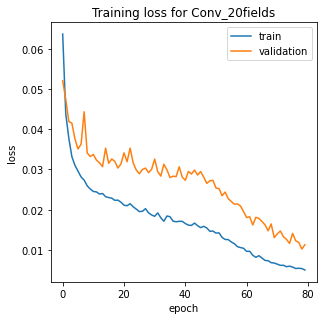

In [285]:
conv2.plot_training()
plt.show()

MSE score of model:  0.016100297274670605
R2 score of model:  0.7629038133063833
Normalised covariance between predicted and actual mass is 0.8746126043820907


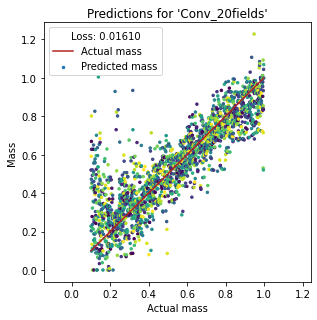

In [279]:
conv2.predict(pred_on_train=True)
conv2.plot_test(color=train_color)
plt.show()

In [297]:
conv2.predict()

MSE score of model:  0.007343615320129824
R2 score of model:  0.8874820043077812
Normalised covariance between predicted and actual mass is 0.9437502027206294


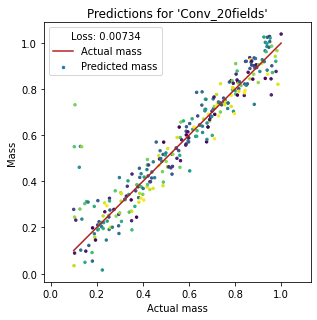

In [298]:
conv2.plot_test(color=test_color)
plt.show()

Cell below finds average score over 20 runs.

In [334]:
n = 10
R2_conv = np.zeros(n)
MSE_conv = np.zeros(n)
for i in range(n):
    if i == 0:
        j = 1
    elif i == n:
        j = n-1
    else:
        j = i
    print("Models trained: ", i, f"Average R2: {R2_conv[:j].mean():.4f}, Average MSE: {MSE_conv[:j].mean():.4f}" "\r", end="", flush=True)
    conv2.reinitialize_weights()
    conv2.train(10,70)
    conv2.predict()
    R2_conv[i] = dense2.r2
    MSE_conv[i] = dense2.mse

print(f"Average R2 of {n} convolutional models: {R2_conv.mean()}")
print(f"Average MSE of {n} convolutional models: {MSE_conv.mean()}")

Average R2 of 10 convolutional models: 0.91595909648564455
Average MSE of 10 convolutional models: 0.005485025419878292


Below we analyze the worst case

In [230]:
shape = y20_pred.shape
abs_err = np.abs(y20_pred-y20_test.reshape(shape))
max_err = np.argmax(abs_err)
abs_err[max_err] = 0
max_err_2 = np.argmax(abs_err)

print("Worst prediction:\n predicted: ", y20_pred[max_err], "\n actual:    ",y20_test.reshape(shape)[max_err] )
print("Second worst prediction: \n predicted: ",  y20_pred[max_err_2], "\n actual:    ",y20_test.reshape(shape)[max_err_2] )


fig, axn = plt.subplots(2, 2, figsize=(4.7747, 5), dpi=300)

for i, ax in enumerate(axn.flat):
    if i < 2:
        ax.imshow(x20_test[max_err,:,:,i], origin="lower")
    else: 
        i = i-2
        ax.imshow(x20_test[max_err_2,:,:,i], origin="lower")
plt.suptitle("The input of the 2 worst predictions")
plt.tight_layout()
plt.show()

print("Second worst prediction: \n predicted: ",  y20_pred[max_err_2], "\n actual:    ",y20_test.reshape(shape)[max_err_2] )

ValueError: cannot reshape array of size 700 into shape (1800,1)

### Visualizing output of convolutional layer

In [135]:
func = K.function([conv_model.get_layer('convolutional_1').input], conv_model.get_layer('convolutional_1').output)
conv_output = func(x20_train[:1,:,:,:])

In [136]:
conv_output.shape

(1, 30, 30, 32)

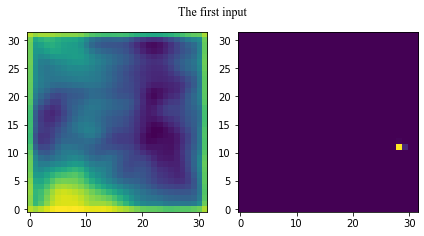

In [118]:
fig, axn = plt.subplots(1, 2)
for i, ax in enumerate(axn):
    ax.imshow(x20_train[0,:,:,i], origin="lower")
plt.suptitle("The first input", y=0.9)
plt.tight_layout()
plt.show()

In [111]:
#Plot output for one filter


plt.imshow(conv_output[0,:,:,0])
plt.title("Output from first convolutional layer")
plt.tight_layout()
plt.show()

NameError: name 'conv_output' is not defined

In [ ]:
#Plot output for two filters
fig, axn = plt.subplots(1, 2)
for i, ax in enumerate(axn):
    ax.imshow(conv_output[0,:,:,i])
plt.suptitle("Output from first convolutional layer")
plt.tight_layout()
plt.show()

In [140]:
filters = conv_model.weights[0]
field_filter = filters[:,:,0,:]
parti_filter= filters[:,:,1,:]
plot_filters = [filters[:,:,0,0], filters[:,:,1,0]]

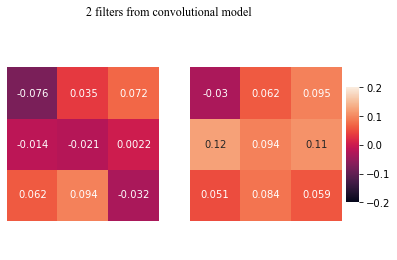

In [141]:
fig, axn = plt.subplots(1,2)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    sns.heatmap(plot_filters[i], ax=ax,
                cbar=i == 0,
                vmin=-0.2, vmax=0.2,
                cbar_ax=None if i else cbar_ax, annot = True)
    ax.invert_yaxis()
    ax.axis('equal')
    ax.axis('off') 
plt.suptitle("2 filters from convolutional model", y=0.9)
plt.show()

## Comparison of models

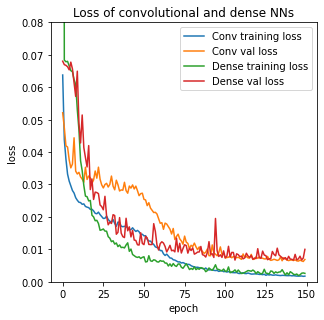

0.8874820043077812
0.8754877309390499


In [319]:
fig, ax = plt.subplots()
conv2.plot_training(fig, ax)
comparison_figure = dense2.plot_training(fig, ax, title="Loss of convolutional and dense NNs",
                     legend=["Conv training loss", "Conv val loss",
                             "Dense training loss", "Dense val loss"])
plt.ylim((0,0.08))
plt.show()
print(conv2.r2)
print(dense2.r2)